# 🍈 Mangosteen Volume Estimation (Images → Volume ml)

**Two approaches in one notebook**:

1) **Feature-based Regression (Lightweight)**
   - Extract simple geometric features from images (diameter/area in cm) using OpenCV.
   - Train **Linear/GBM** regressors to predict volume (ml).

2) **CNN Regression (End-to-End)**
   - Use a small CNN (TensorFlow/Keras) to learn directly from images.
   - Suitable when you have more images and want better generalization.

You can run either (or both). The notebook assumes your files are organized like:

- CSV labels: `/mnt/data/mangosteen-train.csv` with columns:
  - **A**: `mangosteen_id` (e.g., 1, 2, 3 …) matching `i001`, `i002`, …
  - **B**: `weight_g`
  - **D**: `volume_ml`
- Images: e.g., `/mnt/data/i001_crop_group_measured.jpg`, `/mnt/data/i002_crop_group_measured.jpg`, …

> Tip: If your IDs are `i001`, `i002`, the numeric part is matched to `mangosteen_id` with zero-padding to 3 digits.


## 0) Setup

In [61]:
import os, re, math, glob
import numpy as np
import pandas as pd
from typing import List, Tuple

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

import matplotlib.pyplot as plt

IMG_DIR = './data/cropped'  # change if needed
CSV_PATH = './data/mangosteen-train.csv'  # change if needed

df = pd.read_csv(CSV_PATH)
df.columns = [c.strip().lower().replace(' ', '_') for c in df.columns]
display(df.head())

,id,weight_(g),มิลิลิต,volumes_(ml),ลักษณะ,น้ำช่วงแรก:,400
0,1,86.6,500,100,ยาง,NaN,NaN
1,2,53.7,450,50,ชุ่มฉ่ำ,NaN,NaN
2,3,85.7,500,100,ชุ่มฉ่ำ,NaN,NaN
3,4,62.8,470,70,ชุ่มฉ่ำ,NaN,NaN
4,5,45.1,450,50,แก้ว,NaN,NaN


## 1) Link images to labels
We assume files are named like `i001_crop_group_measured.jpg`. We'll build a `filepath` column by zero-padding `mangosteen_id`.

In [62]:
def id_to_fname(idx:int)->str:
    return f"i{idx:03d}_crop_group_measured.jpg"

df['filename'] = df['id'].astype(int).apply(id_to_fname)
df['filepath'] = df['filename'].apply(lambda f: os.path.join(IMG_DIR, f))
df['exists'] = df['filepath'].apply(os.path.exists)
print('Found images:', df['exists'].sum(), '/', len(df))
display(df[['id','filename','filepath','exists','weight_(g)','volumes_(ml)']].head(10))

Found images: 75 / 75


,id,filename,filepath,exists,weight_(g),volumes_(ml)
0,1,i001_crop_group_measured.jpg,./data/cropped/i001_crop_group_measured.jpg,True,86.6,100
1,2,i002_crop_group_measured.jpg,./data/cropped/i002_crop_group_measured.jpg,True,53.7,50
2,3,i003_crop_group_measured.jpg,./data/cropped/i003_crop_group_measured.jpg,True,85.7,100
3,4,i004_crop_group_measured.jpg,./data/cropped/i004_crop_group_measured.jpg,True,62.8,70
4,5,i005_crop_group_measured.jpg,./data/cropped/i005_crop_group_measured.jpg,True,45.1,50
5,6,i006_crop_group_measured.jpg,./data/cropped/i006_crop_group_measured.jpg,True,89.0,100
6,7,i007_crop_group_measured.jpg,./data/cropped/i007_crop_group_measured.jpg,True,68.6,80
7,8,i008_crop_group_measured.jpg,./data/cropped/i008_crop_group_measured.jpg,True,68.6,80
8,9,i009_crop_group_measured.jpg,./data/cropped/i009_crop_group_measured.jpg,True,41.1,50
9,10,i010_crop_group_measured.jpg,./data/cropped/i010_crop_group_measured.jpg,True,56.0,60


## 2) Feature-based extraction (OpenCV)
We try to estimate a robust **diameter** for each fruit. Many of your images include a colored circular overlay (magenta/cyan), which makes **HoughCircles** viable.

Algorithm (simple baseline):
1. Read image (BGR → RGB)
2. Convert to grayscale, apply blur
3. Use `cv2.HoughCircles` to find circles; keep the largest (assumed fruit boundary)
4. If a circle is found, compute: `diameter_px`, and (optionally) convert to **cm** if you know `ppcm` (pixels per cm). If not available per-image, you can use an average `ppcm`.
5. Derived features: `diameter_cm`, `area_cm2`, `perimeter_cm`

> If HoughCircles fails for some images, the code will fallback to `NaN`. You can drop those rows or manually tune parameters per dataset.

In [63]:
import cv2  # requires opencv-python

DEFAULT_PPCM = 6.9  # fallback pixels-per-cm; adjust/estimate from a few samples

def extract_circle_features(img_path:str, ppcm:float=DEFAULT_PPCM):
    """
    Returns: dict with diameter_cm, area_cm2, perimeter_cm, success
    """
    try:
        img = cv2.imread(img_path)
        if img is None:
            return {'diameter_cm':np.nan,'area_cm2':np.nan,'perimeter_cm':np.nan,'success':False}
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray = cv2.medianBlur(gray, 5)

        circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=1.2, minDist=40,
                                   param1=100, param2=30, minRadius=20, maxRadius=200)
        if circles is None:
            return {'diameter_cm':np.nan,'area_cm2':np.nan,'perimeter_cm':np.nan,'success':False}
        circles = np.uint16(np.around(circles))[0, :]
        # largest radius first
        r = np.max(circles[:,2])
        diameter_px = 2*r
        diameter_cm = float(diameter_px) / float(ppcm)
        radius_cm = diameter_cm/2.0
        area_cm2 = math.pi * (radius_cm**2)
        perimeter_cm = 2*math.pi*radius_cm
        return {'diameter_cm':diameter_cm,'area_cm2':area_cm2,'perimeter_cm':perimeter_cm,'success':True}
    except Exception as e:
        print('extract failed:', img_path, e)
        return {'diameter_cm':np.nan,'area_cm2':np.nan,'perimeter_cm':np.nan,'success':False}

features = []
for fp in df['filepath']:
    if os.path.exists(fp):
        features.append(extract_circle_features(fp, DEFAULT_PPCM))
    else:
        features.append({'diameter_cm':np.nan,'area_cm2':np.nan,'perimeter_cm':np.nan,'success':False})

feat_df = pd.DataFrame(features)
df_feat = pd.concat([df.reset_index(drop=True), feat_df], axis=1)
print('Feature success rate:', df_feat['success'].mean())
display(df_feat.head())

Feature success rate: 1.0


,id,weight_(g),มิลิลิต,volumes_(ml),ลักษณะ,น้ำช่วงแรก:,400,filename,filepath,exists,diameter_cm,area_cm2,perimeter_cm,success
0,1,86.6,500,100,ยาง,NaN,NaN,i001_crop_group_measured.jpg,./data/cropped/i001_crop_group_measured.jpg,True,39.710145,1238.490916,124.753100,True
1,2,53.7,450,50,ชุ่มฉ่ำ,NaN,NaN,i002_crop_group_measured.jpg,./data/cropped/i002_crop_group_measured.jpg,True,28.405797,633.729381,89.239443,True
2,3,85.7,500,100,ชุ่มฉ่ำ,NaN,NaN,i003_crop_group_measured.jpg,./data/cropped/i003_crop_group_measured.jpg,True,34.202899,918.788828,107.451575,True
3,4,62.8,470,70,ชุ่มฉ่ำ,NaN,NaN,i004_crop_group_measured.jpg,./data/cropped/i004_crop_group_measured.jpg,True,42.028986,1387.355294,132.037952,True
4,5,45.1,450,50,แก้ว,NaN,NaN,i005_crop_group_measured.jpg,./data/cropped/i005_crop_group_measured.jpg,True,43.478261,1484.684619,136.590985,True


## 3) Train simple regressors (Feature-based)
We try two models: **Linear Regression** and **Gradient Boosting**.

Target: `volume_ml`

Linear: MAE=16.871, R2=-0.034
GBR: MAE=14.073, R2=-0.009


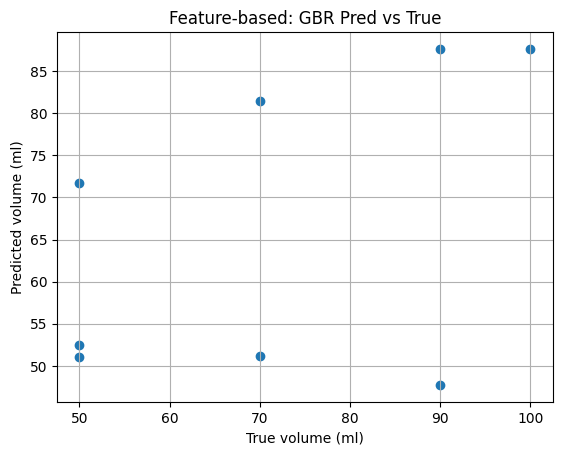

In [64]:
use_cols = ['diameter_cm','area_cm2','perimeter_cm']
train_df = df_feat.dropna(subset=use_cols + ['volumes_(ml)']).copy()
X = train_df[use_cols].values
y = train_df['volumes_(ml)'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

models = {
    'Linear': LinearRegression(),
    'GBR': GradientBoostingRegressor(random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, pred)
    # rmse = mean_squared_error(y_test, pred, squared=False)
    r2 = r2_score(y_test, pred)
    print(f"{name}: MAE={mae:.3f}, R2={r2:.3f}")

# Plot predicted vs true
plt.figure()
best = models['GBR']
pred_best = best.predict(X_test)
plt.scatter(y_test, pred_best)
plt.xlabel('True volume (ml)')
plt.ylabel('Predicted volume (ml)')
plt.title('Feature-based: GBR Pred vs True')
plt.grid(True)
plt.show()

## 4) (Optional) CNN Regression (TensorFlow/Keras)
If you have TensorFlow installed, you can train a small CNN end-to-end.

This section:
1. Builds a simple dataset pipeline that reads each image and pairs it with `volume_ml`.
2. Defines a compact CNN.
3. Trains with MAE loss.

> If TensorFlow isn't available in your environment, skip this cell.

In [65]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge

X = train_df[use_cols].values
y = train_df['volumes_(ml)'].values

kf = KFold(n_splits=25, shuffle=True, random_state=42)
maes, rmses, r2s = [], [], []

for tr, va in kf.split(X):
    model = Ridge(alpha=1)  # ลอง 0.1, 1, 10 แล้วเลือกที่ดีที่สุด
    model.fit(X[tr], y[tr])
    p = model.predict(X[va])
    maes.append(mean_absolute_error(y[va], p))
    # rmses.append(mean_squared_error(y[va], p, squared=False))
    r2s.append(r2_score(y[va], p))

print(f"Ridge 5-fold: MAE={np.mean(maes):.3f}±{np.std(maes):.3f}, "
      f"R2={np.mean(r2s):.3f}±{np.std(r2s):.3f}")


Ridge 5-fold: MAE=19.849±7.213, R2=-70.224±327.974


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,809 (108.63 KB)

 Trainable params: 27,809 (108.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 419ms/step - loss: 68.8057 - mae: 68.8057 - val_loss: 64.0611 - val_mae: 64.0611
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 67.9234 - mae: 67.9234 - val_loss: 62.6355 - val_mae: 62.6355
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 65.9992 - mae: 65.9992 - val_loss: 59.4643 - val_mae: 59.4643
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 61.7711 - mae: 61.7711 - val_loss: 52.6407 - val_mae: 52.6407
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 52.9296 - mae: 52.9296 - val_loss: 39.0372 - val_mae: 39.0372
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 35.8701 - mae: 35.8701 - val_loss: 17.6673 - val_mae: 17.6673
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 19.3024 - mae: 19.3024 - val_loss: 25.0755 - val_mae: 25.0755
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 24.3033 - mae: 24.3033 - val_loss: 26.8543 - val_mae: 26.8543
Epoch 9/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/ste

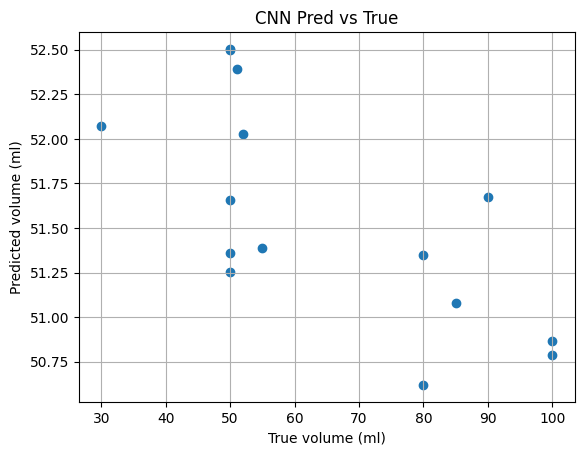

In [66]:
try:
    import tensorflow as tf
    from tensorflow.keras import layers, models
    TF_OK = True
except Exception as e:
    print('TensorFlow not available, skip CNN section:', e)
    TF_OK = False

IMG_SIZE = (224, 224)

if TF_OK:
    df_ok = df[df['exists']].copy()
    df_ok = df_ok.dropna(subset=['volumes_(ml)'])
    paths = df_ok['filepath'].tolist()
    targets = df_ok['volumes_(ml)'].astype('float32').tolist()

    X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(paths, targets, test_size=0.2, random_state=0)

    def parse_img(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMG_SIZE)
        img = tf.cast(img, tf.float32) / 255.0
        return img, tf.cast(label, tf.float32)

    train_ds = tf.data.Dataset.from_tensor_slices((X_train_p, y_train_p)).map(parse_img, num_parallel_calls=tf.data.AUTOTUNE).batch(16).prefetch(tf.data.AUTOTUNE)
    test_ds  = tf.data.Dataset.from_tensor_slices((X_test_p, y_test_p)).map(parse_img, num_parallel_calls=tf.data.AUTOTUNE).batch(16).prefetch(tf.data.AUTOTUNE)

    model = models.Sequential([
        layers.Input(shape=(*IMG_SIZE,3)),
        layers.Conv2D(16, 3, activation='relu'), layers.MaxPooling2D(),
        layers.Conv2D(32, 3, activation='relu'), layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation='relu'), layers.GlobalAveragePooling2D(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mae', metrics=['mae'])
    model.summary()

    cb = [tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
    hist = model.fit(train_ds, validation_data=test_ds, epochs=30, callbacks=cb)

    # Evaluate
    y_pred = model.predict(test_ds).squeeze()
    y_true = np.array(list(y_test_p))
    mae = mean_absolute_error(y_true, y_pred)
    # rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    print(f"CNN: MAE={mae:.3f}, R2={r2:.3f}")

    plt.figure()
    plt.scatter(y_true, y_pred)
    plt.xlabel('True volume (ml)')
    plt.ylabel('Predicted volume (ml)')
    plt.title('CNN Pred vs True')
    plt.grid(True)
    plt.show()

## 5) Save predictions (optional)

In [67]:
# # Example for saving predictions from the GBR feature-based model
# if 'GBR' in locals():
#     full_pred = None
#     try:
#         full_pred = models['GBR'].predict(df_feat[use_cols].values)
#     except:
#         pass
#     if full_pred is not None:
#         out = df_feat.copy()
#         out['pred_volume_ml_gbr'] = full_pred
#         OUT_CSV = '/mnt/data/volume_predictions.csv'
#         out.to_csv(OUT_CSV, index=False)
#         print('Saved:', OUT_CSV)

In [68]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge

X = train_df[use_cols].values
y = train_df['volumes_(ml)'].values

kf = KFold(n_splits=5, shuffle=True, random_state=42)
maes, rmses, r2s = [], [], []

for tr, va in kf.split(X):
    model = Ridge(alpha=1.0)  # ลอง 0.1, 1, 10 แล้ว���ลือกที่ดีที่สุด
    model.fit(X[tr], y[tr])
    p = model.predict(X[va])
    maes.append(mean_absolute_error(y[va], p))
    # rmses.append(mean_squared_error(y[va], p, squared=False))
    r2s.append(r2_score(y[va], p))

print(f"Ridge 5-fold: MAE={np.mean(maes):.3f}±{np.std(maes):.3f}, "
      f"R2={np.mean(r2s):.3f}±{np.std(r2s):.3f}")


Ridge 5-fold: MAE=19.584±2.870, R2=-0.144±0.093
